# Useful Ancillary Skills for Regression

In [Notebook 37](https://jqbond.github.io/CEN587/Notebooks/587-N37.html), we covered the fundamental, mathematical basis for constructing interpolating polynomials and regression polynomials. Both of these tools can be used to model trends in data. They are especially valuable to us because they allow us to use measurements and observations to generate a continuous function that describes the relationship between an input (independent) variable and an output (observable or measured variable). Once we have this function, we can use it to make predictions about the value that an observable will take on at values of the input variable that we did not measure. Here, we summararize a few ancillary statistical tools that are often used alongside regression analysis to quantify goodness of fit and allow us to compare different models. Now that we understand the mathematics of the approach, we will also introduce Python functions that automate some of the regression process, similar to what Trendline or LINEST would do in Excel. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from math import ceil, floor
import scipy.stats as stats
import time

## A Recap

Let's start by recalling the 11 $(x,y)$ pairs from [Notebook 37](https://jqbond.github.io/CEN587/Notebooks/587-N37.html). We will use the same seed for our random number generator here, which will generate the same set of "random" $(x,y)$ pairs as before. We do this here to ensure that we get the same regression results in the two notebooks, and also that we get the same regression results each time we run the Notebook.  If we did not set the RNG seed, we would get a different data set each time the Notebook kernel is restarted, which makes it difficult to consistently discuss the observed trends.

In the cell below, we'll generate the data and fit a first order model to it, and overlay the results graphically as we did in the previous Notebooks. Subsequently, we'll establish a systematic way for reporting the results of linear regression analysis. This will allow us to quickly assess "goodness of fit" and to compare the quality of fit for various models.

[0.22733602 0.31675834 0.79736546 0.67625467 0.39110955 0.33281393
 0.59830875 0.18673419 0.67275604 0.94180287 0.24824571] 

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 

[-0.90421001  0.92118569]


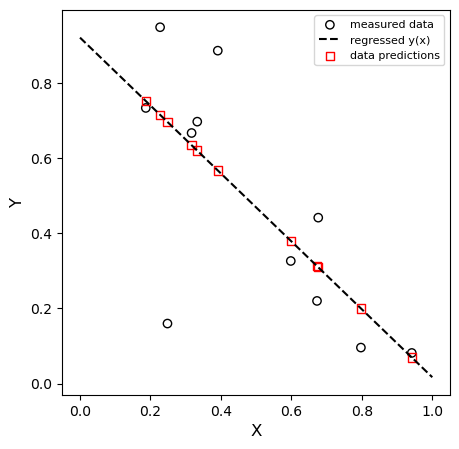

In [2]:
#########################################################################################################################
# set the seed for randon number generation; this ensures we get the same "random" number set each time we run the cell #
#########################################################################################################################
 
rng   = np.random.default_rng(12345)

#########################################################################################################################
# Generate 11 random x values and 11 random y values; print the results to screen                                       #
#########################################################################################################################

xdata = rng.random(11)
ydata = rng.random(11)
print(xdata, '\n')
print(ydata, '\n')

######################################################################################
# Generate Y array of observables/measured quantities                                #
######################################################################################

Y = ydata

######################################################################################
# Generate truncated vandermonde matrix @ second order                               #
# This has 4 columns, x^3, x^2, x^1, x^0                                             #
######################################################################################

X = np.vander(xdata, 2)

######################################################################################
# Solve for optimum set of coefficients for the 2nd order model, display results     #
######################################################################################

A = np.linalg.solve(X.T@X, X.T@Y) 
print(A)

#################################################################################
# Define large array of x values for generating smooth continuous line plot     #
#################################################################################

xline = np.linspace(0, 1, 100)

######################################################################################
# Define lambda function for best fit 2nd order model using regressed coefficients   #
######################################################################################

yline = lambda x: A[0]*x + A[1]

######################################################################################
# Overlay measured y data, predicted y data, and continuous 2nd order function y(x)  #
######################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'regressed y(x)')
plt.scatter(xdata, X@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

### Ancillary Skills

Whenver we perform least squares regression, we are minimizing the residual sum of squares. This quantity is defined as:

$$SSE = \sum_i (y_i - \hat{y}_i)^2$$

It can be calculated using a summation, which is relatively straighforward in Python using `numpy.sum()` and operating on arrays of data. Alternatively, when solving linear regression problems using $X$, $Y$, and $A$ matrices/arrays, we can calculate the residual sum of squares using the following matrix formula:

$$SSE = (Y - XA)^T(Y - XA)$$

In `numpy` the above expression would be written using the `@` and `.T` operators as:

    SSE = (Y - X@A).T@(Y - X@A)

It may not look like it at first, but if you write out the matrix product, you should see that you generate the exact same right hand side as the form using a summation operator. One thing that we should be mindful of is that the residual sum of squares is a function of the number of data points in our system and the size of the measurements that we are working with. For example, if we work with a data set comprised of 1000 $(x,y)$ pairs, it will usually have a larger residual sum of squares than a data set comprised of 10 $(x,y)$ pairs. In addition, if our measured values of $y$ are on the order of 1000, we will generally observe a larger absolute residual sum of squares than if our measured values of $y$ are on the order of $10^{-3}$. Because of these issues, the absolute magnitude of residual sum of squares is not an especially meaningful way to quantify the error in a given fit or optimization, and we frequently look at other metrics to quantify goodness of fit. For example, the Mean Square Error (MSE) is useful because it normalizes residual sum of squares by the number of measurements; as such, it represents the ***average square error*** in our data fit, which can be used to assess models fit to data sets of different size:

$$MSE = \frac{SSE}{n_m}$$

In this expression, $n_m$ is the number of data points/measurements. We can use the MSE to then generate the root mean square error (RMSE), which is a good approximation of the absolute value of the displacement (error) between our model and our measurement.

$$RMSE = \sqrt{MSE}$$

The total sum of squares is used to quantify the error between the measurement and the mean of measurments. Basically, this is the residual sum of squares that results if we assume that our model is that $y = \bar{y}$ for any value of $x$:

$$SST = \sum_i (y_i - \bar{y}_i)$$

We can use the residual sum of squares and the total sum of squares to can calculate the coefficient of determination (the beloved $R^2$):

$$R^2 = 1 - \frac{SSE}{SST}$$

It is generally also useful to quantify the level of uncertainty in the parameters (e.g., coefficients) that we estimate using regression analysis. For linear regression, there is a well-defined procedure for doing so. First, we need to know the variance for the regressed model, $\sigma^2$. This is generally unknown, but we assume that it can be approximated:

$$\sigma^2 \approx s^2$$

This is convenient because $s^2$ can be calculated from our data:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Here $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters. The difference between these two, $n_m - n_p$ is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

With $s^2$ calculated, we can estimate the covariance matrix:

$$COV = s^2(X^TX)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

Noting that this may throw a warning if off-diagonal elements of the covariance matrix are negative.

From that, we get the standard error in the slope from `se[0,0]` and the standard error in the intercept from `se[1,1]`, i.e., the diagonal elements.

One can then use these quantities with relevant values from the [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

In this formula, the value of the t-distribution is obtained at a specified confidence level $q$ and for the number of degrees of freedom in the regression. Finally, it is convenient to remember that, because we are working with a linear system defined in terms of matrices, we can, predict values of the observable, measured quantityby multiplying the Vandermonde matrix by the array of regressed coefficients:

$$\hat{Y} = X\hat{A}$$

The formulae given above are all embedded along with the least squares calculation in the cell below; this block will be used as a standard component of linear regression analysis for the remainder of the course.

```{tip}
The calculations below are general and can be applied to any linear regression once the $X$ and $Y$ arrays are defined!
```

m    = -0.90 +/- 0.65
b    = 0.92 +/- 0.65
SSE  = 0.49
SST  = 1.03
MSE  = 0.04
RMSE = 0.21
R2   = 0.52


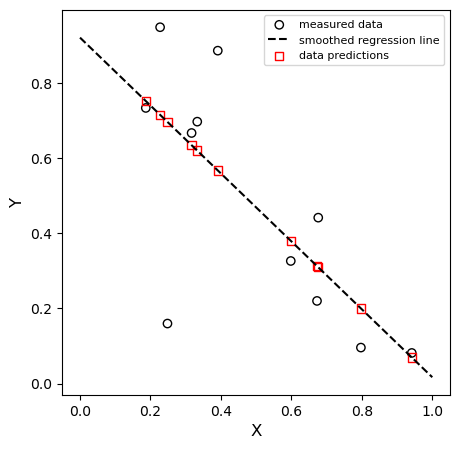

In [6]:
#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)       #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE,  R2]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    else:
        print(f'{label:4s} = {value:0.2f}')


############################################################################################
# Visualizing results; overlay data, predictions, and continuous regressed y(x)            #
############################################################################################

xline = np.linspace(0, 1, 100)
yline = lambda x: A[0]*x + A[1]
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, X@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

## Python will do all this stuff for you if you want...

For your reference, Python includes most of the above calculations in its various options for automatically through either `numpy.polyfit()` or `numpy.linalg.leastsq()`.  The cell below shows the use of `numpy.polyfit()` to fit first, second, and third order polynomials to the data.  You can see that this requires much less work on our part; the trade off is that the calculations are not transparent to us, so lose a bit of insight about how linear regression actually works. Regardless, we get the same coefficients as we did in [Notebook 37](https://jqbond.github.io/CEN587/Notebooks/587-N37.html)

In [ ]:
#####################################################################################################
# First order regression using matrix methods                                                       #
#####################################################################################################

Y1 = ydata
X1 = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order
A1 = np.linalg.solve(X1.T@X1, X1.T@Y1) 

#####################################################################################################
# First order regression using numpy.polyfit()                                                      #
#####################################################################################################

A1np_poly = np.polyfit(xdata, ydata, 1)

#####################################################################################################
# Second order regression using matrix methods                                                      #
#####################################################################################################

Y2 = ydata
X2 = np.vander(xdata,3) #This creates the X matrix shown above, truncating at 1st order
A2 = np.linalg.solve(X2.T@X2, X2.T@Y2)

#####################################################################################################
# Second order regression using numpy.polyfit()                                                     #
#####################################################################################################

A2np_poly = np.polyfit(xdata, ydata, 2)

#####################################################################################################
# Third order regression using matrix methods                                                      #
#####################################################################################################

Y3 = ydata
X3 = np.vander(xdata,4) #This creates the X matrix shown above, truncating at 1st order
A3 = np.linalg.solve(X3.T@X3, X3.T@Y3)

#####################################################################################################
# Third order regression using numpy.polyfit()                                                      #
#####################################################################################################

A3np_poly = np.polyfit(xdata, ydata, 3) #Fit a third order polynomial to data, four coefficients

#####################################################################################################
# Compare coefficients obtained using matrix methods vs. numpy.polyfit()                            #
#####################################################################################################

print(np.vstack([A1, A1np_poly]), '\n')
print(np.vstack([A2, A2np_poly]), '\n')
print(np.vstack([A3, A3np_poly]), '\n')

[[-0.90421001  0.92118569]
 [-0.90421001  0.92118569]] 

[[-0.69969354 -0.14991027  0.76170812]
 [-0.69969354 -0.14991027  0.76170812]] 

[[ 4.85887321 -9.04727267  4.12600401  0.14299066]
 [ 4.85887321 -9.04727267  4.12600401  0.14299066]] 



Regression tools in `numpy` are very nice because in addition to performing the regression (using `np.polyfit()`), they will also automate construction of the regressed polynomial function using `np.polyval()`. 

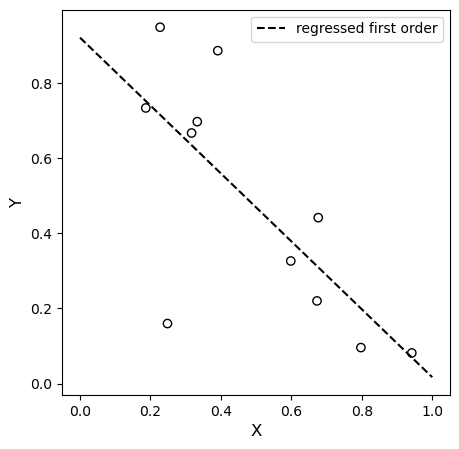

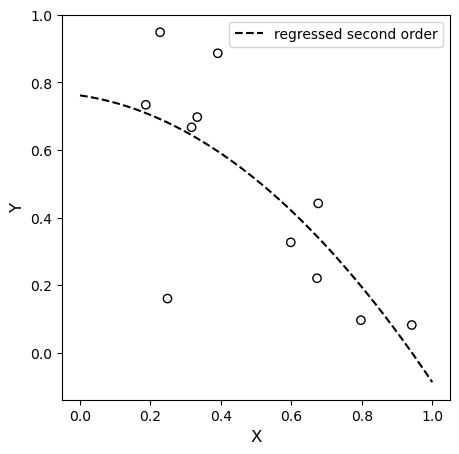

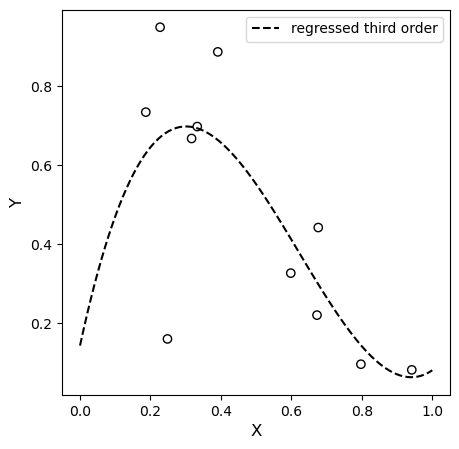

In [ ]:
######################################################################################
# Evaluate the best fit first order model at all 100 values in xline                 #
######################################################################################

first  = np.polyval(A1np_poly, xline)

######################################################################################
# Evaluate the best fit second order model at all 100 values in xline                #
######################################################################################

second = np.polyval(A2np_poly, xline)

######################################################################################
# Evaluate the best fit third order model at all 100 values in xline                 #
######################################################################################

third  = np.polyval(A3np_poly, xline)

######################################################################################
# Overlay observed data and the regressed y(x) result for first order model          #
######################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, first, color = 'black', linestyle = 'dashed', label = 'regressed first order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

######################################################################################
# Overlay observed data and the regressed y(x) result for second order model         #
######################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, second, color = 'black', linestyle = 'dashed', label = 'regressed second order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

######################################################################################
# Overlay observed data and the regressed y(x) result for third order model          #
######################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, third, color = 'black', linestyle = 'dashed', label = 'regressed third order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

It is also worth mentioning that `numpy` has a built in least squares version of `np.linalg.solve()`, which has a very similar syntax to  `np.linalg.solve()` in that it operates directly on the $X$ matrix and $Y$ array -- no need for transposes -- but it returns least squares regressed coefficients. See results below for a first and second order regression of our the "tall" matrices above. A nice feature of `np.linalg.lstsq()` is that it will calculate SSE. It returns rank and singular values as well, though we won't usually use these things in this course. 

In [ ]:
#########################################################################################
# Performing regression for 1st, 2nd, and 3rd order using numpy.linalg.lstsq()          #
#########################################################################################

A1np_lsq, SSE1, rank1, sing1 = np.linalg.lstsq(X1, Y1, rcond = None)
A2np_lsq, SSE2, rank2, sing2 = np.linalg.lstsq(X2, Y2, rcond = None)
A3np_lsq, SSE3, rank3, sing3 = np.linalg.lstsq(X3, Y3, rcond = None)

#########################################################################################
# Print coefficients; compare matrix method, numpy.polyval(), and numpy.linalg.lstsq()  #
#########################################################################################

print(np.vstack([A1, A1np_poly, A1np_lsq]), '\n')
print(np.vstack([A2, A2np_poly, A2np_lsq]), '\n')
print(np.vstack([A3, A3np_poly, A3np_lsq]), '\n')

#########################################################################################
# Print residual sum of squares for 1st, 2nd, and 3rd order fits                        #
# For a given data set, SSE will decrease as the order of the polynomial increases      #
# This does not mean that a higher order polynomial is "better" per se                  #
# But it does mean that a higher order polynomial more closely predicts measured values #
#########################################################################################

print(SSE1, SSE2, SSE3)


[[-0.90421001  0.92118569]
 [-0.90421001  0.92118569]
 [-0.90421001  0.92118569]] 

[[-0.69969354 -0.14991027  0.76170812]
 [-0.69969354 -0.14991027  0.76170812]
 [-0.69969354 -0.14991027  0.76170812]] 

[[ 4.85887321 -9.04727267  4.12600401  0.14299066]
 [ 4.85887321 -9.04727267  4.12600401  0.14299066]
 [ 4.85887321 -9.04727267  4.12600401  0.14299066]] 

[0.49163018] [0.47936939] [0.45149249]
